In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.iv import IV2SLS

In [2]:
data = pd.read_csv('./data/Project1Data.csv')

In [3]:
Y = data['readmission_rate']

T = data['treatment_type']

IV = data[['distance_to_hospital', 'insurance_coverage', 'hospital_capacity']]

controls = data[['age', 'sex', 'bmi', 'income']]

In [4]:
first_stage_exog = pd.concat([IV, controls], axis=1)
first_stage_exog = sm.add_constant(first_stage_exog)

In [5]:
first_stage_model = sm.OLS(T, first_stage_exog).fit()
first_stage_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         treatment_type   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     23.95
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           2.96e-23
Time:                        21:29:40   Log-Likelihood:                -50.871
No. Observations:                 200   AIC:                             117.7
Df Residuals:                     192   BIC:                             144.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7608      0.340     -5.181      0.000      -2.431      -1.090
distance_to_hospital     0.0151      0.012      1.212      0.227      -0.009       0.040
insurance_coverage      -0.0205      0.046     -0.442      0.659      -0.112       0.071
hospital_capacity        0.0005      0.001      0.500      0.618      -0.001       0.002
age                      0.0229      0.002     12.574      0.000       0.019       0.027
sex                     -0.0123      0.046     -0.267      0.790      -0.103       0.078
bmi                      0.0236      0.011      2.163      0.032       0.002       0.045
income               -3.287e-06   1.45e-06     -2.267      0.024   -6.15e-06   -4.28e-07
==============================================================================
Omnibus:                       67.547   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.468
Skew:                           0.138   Prob(JB):                      0.00323
Kurtosis:                       1.860   Cond. No.                     7.79e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
first_stage_instruments = sm.OLS(T, sm.add_constant(IV)).fit()
first_stage_instruments.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         treatment_type   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.4788
Date:                Sun, 13 Oct 2024   Prob (F-statistic):              0.697
Time:                        21:29:40   Log-Likelihood:                -112.90
No. Observations:                 200   AIC:                             233.8
Df Residuals:                     196   BIC:                             247.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2839      0.206      1.376      0.170      -0.123       0.691
distance_to_hospital    -0.0139      0.017     -0.843      0.400      -0.046       0.019
insurance_coverage       0.0390      0.062      0.627      0.531      -0.084       0.162
hospital_capacity        0.0007      0.001      0.583      0.561      -0.002       0.003
==============================================================================
Omnibus:                       37.400   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.624
Skew:                           1.206   Prob(JB):                     1.02e-11
Kurtosis:                       2.494   Cond. No.                         704.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Condition number (Cond. No. = 704): The condition number is an indicator for detecting multicollinearity problems. Usually, a condition number of more than 30 indicates multicollinearity. If it exceeds 100, it means that the collinearity is very serious and the condition number is far beyond the threshold, which strongly indicates that there is a multicollinearity problem. Consider further analysis through the correlation coefficient matrix and VIF to choose to delete one of the highly correlated variables.

In [7]:
variables = first_stage_exog.drop('const', axis=1)
vif_data = pd.DataFrame()
vif_data['feature'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif_data

,feature,VIF
0,distance_to_hospital,23.974335
1,insurance_coverage,2.306993
2,hospital_capacity,16.976329
3,age,22.554804
4,sex,1.763178
5,bmi,47.987520
6,income,10.557749


<Axes: >

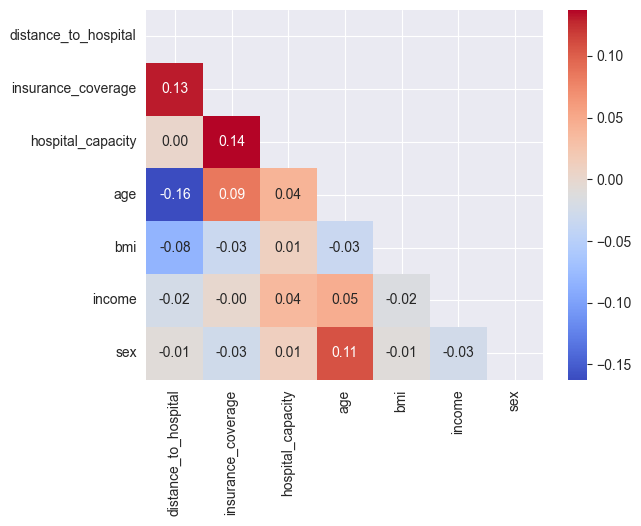

In [8]:
correlation_matrix = data[['distance_to_hospital', 'insurance_coverage', 'hospital_capacity', 'age', 'bmi', 'income', 'sex']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, mask=mask)

The VIF test shows that bmi has the highest VIF value, so we try to exclude BMI to reduce the impact of collinearity on the model and improve the independence between variables. Moreover, in this correlation matrix, the correlation coefficients between most variables are very close to 0, indicating that the direct linear correlation between the variables is very low. This means that from the perspective of the correlation between the two variables, collinearity is not obvious. This shows that the high VIF value is not necessarily caused by a simple high correlation between two variables. It is further confirmed that there is multicollinearity, that is, a variable may be a combination of multiple other variables, which leads to an increase in the standard error of the regression coefficient.

In [9]:
variables_wo_bmi = ['distance_to_hospital', 'insurance_coverage', 'hospital_capacity', 'age', 'sex','income']
X = data[variables_wo_bmi]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Adjusted VIFs:")
print(vif_data)

Adjusted VIFs:
                feature        VIF
0  distance_to_hospital  17.117482
1    insurance_coverage   2.294438
2     hospital_capacity  15.068005
3                   age  17.387670
4                   sex   1.762373
5                income   9.961415


After excluding BIM, the overall VIF of the variable is significantly reduced, so we believe that excluding BIM has a significant effect on reducing multicollinearity.

In [10]:
Y = data['readmission_rate']
endog = data[['treatment_type']]
IVs = data[['distance_to_hospital', 'insurance_coverage', 'hospital_capacity']]
exog = data[['age', 'income', 'sex']]

first_stage = sm.OLS(endog, pd.concat([IVs, controls], axis=1)).fit()
print("First-stage regression results:")
print(first_stage.summary())

iv_model = IV2SLS(dependent=Y, exog=exog, endog=endog, instruments=IVs).fit()
iv_model.summary

First-stage regression results:
                                 OLS Regression Results                                
Dep. Variable:         treatment_type   R-squared (uncentered):                   0.538
Model:                            OLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              32.05
Date:                Sun, 13 Oct 2024   Prob (F-statistic):                    2.98e-29
Time:                        21:29:41   Log-Likelihood:                         -63.955
No. Observations:                 200   AIC:                                      141.9
Df Residuals:                     193   BIC:                                      165.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                      0.9686
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9679
No. Observations:                 200   F-statistic:                    6106.5
Date:                Sun, Oct 13 2024   P-value (F-stat)                0.0000
Time:                        21:29:41   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
==================================================================================
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
age                0.1781     0.0148     12.062     0.0000      0.1492      0.2070
income          1.086e-05  1.301e-05     0.8350     0.4037  -1.463e-05   3.635e-05
sex                0.0547     0.2973     0.1840     0.8540     -0.5279      0.6373
treatment_type    -1.4184     1.1529    -1.2304     0.2186     -3.6780      0.8411
==================================================================================

Endogenous: treatment_type
Instruments: distance_to_hospital, insurance_coverage, hospital_capacity
Robust Covariance (Heteroskedastic)
Debiased: False
"""

在降低了共线性之后，我们尝试使用三个工具变量的组合同时估计治疗类别对再住院率的影响，但treatment type的p-value并不显著，需要进一步分析

In [11]:
print("Overidentification Test (Sargan's Test):")
print(f"Statistic: {iv_model.sargan.stat:.4f}")
print(f"P-value: {iv_model.sargan.pval:.4f}")

Overidentification Test (Sargan's Test):
Statistic: 45.2500
P-value: 0.0000


After Sargan validation, the p-value is less than 0.05, which indicates that there is a correlation between the instrumental variables and the error term, which means that these instrumental variables are not exogenous, and the model may have an endogeneity problem of instrumental variables, and further ablation analysis of the instrumental variables is needed.

In [12]:
instruments_valid = data[['insurance_coverage', 'distance_to_hospital']]
first_stage_valid = sm.OLS(endog, pd.concat([exog, instruments_valid], axis=1)).fit()
print("First-stage regression results with valid instruments:")
print(first_stage_valid.summary())

iv_model = IV2SLS.from_formula('readmission_rate ~ age + income + sex + [treatment_type ~ distance_to_hospital + insurance_coverage]', data=data)
iv_results = iv_model.fit()
print(iv_results.summary)

# Sargan 检验
print(f"Sargan test statistic: {iv_results.sargan.stat}")
print(f"Sargan P-value: {iv_results.sargan.pval}")


First-stage regression results with valid instruments:
                                 OLS Regression Results                                
Dep. Variable:         treatment_type   R-squared (uncentered):                   0.510
Model:                            OLS   Adj. R-squared (uncentered):              0.498
Method:                 Least Squares   F-statistic:                              40.64
Date:                Sun, 13 Oct 2024   Prob (F-statistic):                    1.60e-28
Time:                        21:29:41   Log-Likelihood:                         -69.677
No. Observations:                 200   AIC:                                      149.4
Df Residuals:                     195   BIC:                                      165.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t| 

In [13]:
iv_model = IV2SLS.from_formula('readmission_rate ~ age + income + sex + [treatment_type ~ distance_to_hospital + hospital_capacity]', data=data)
iv_results = iv_model.fit()

# Sargan 检验
print(f"Sargan test statistic: {iv_results.sargan.stat}")
print(f"Sargan p-value: {iv_results.sargan.pval}")

Sargan test statistic: 45.096166313906316
Sargan p-value: 1.8759216402486345e-11


In [14]:
instruments_valid = data[['insurance_coverage', 'hospital_capacity']]
first_stage_valid = sm.OLS(endog, pd.concat([exog, instruments_valid], axis=1)).fit()
print("First-stage regression results with valid instruments:")
print(first_stage_valid.summary())

iv_model = IV2SLS.from_formula('readmission_rate ~ age + income + sex + [treatment_type ~ insurance_coverage + hospital_capacity]', data=data)
iv_results = iv_model.fit()

print(iv_results.summary)
# Sargan 检验
print(f"Sargan Test statistic: {iv_results.sargan.stat}")
print(f"Sargan P-value: {iv_results.sargan.pval}")

First-stage regression results with valid instruments:
                                 OLS Regression Results                                
Dep. Variable:         treatment_type   R-squared (uncentered):                   0.489
Model:                            OLS   Adj. R-squared (uncentered):              0.476
Method:                 Least Squares   F-statistic:                              37.39
Date:                Sun, 13 Oct 2024   Prob (F-statistic):                    8.81e-27
Time:                        21:29:41   Log-Likelihood:                         -73.854
No. Observations:                 200   AIC:                                      157.7
Df Residuals:                     195   BIC:                                      174.2
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|   

From these sets of experimental results, we can see that the two pairs of distance_to_hospital+insurance_coverage and insurance_coverage + hospital_capacity satisfy the exogeneity condition. However, when all instrumental variables are combined together, the exogeneity condition will not be met, although distance_to_hospital and hospital_capacity are each related to the endogenous condition. The biological variable treatment_type is significantly correlated (the correlation condition of the instrumental variable is met). The possible reason for this phenomenon is that both distance_to_hospital and hospital_capacity may indirectly affect readmission_rate through treatment_type. The reason for this phenomenon may be multiple pathways of action. For both instrumental variables used, they may directly affect readmission_rate through different mechanisms. For example:
1. Distance_to_hospital: It mainly affects readmission rates indirectly by affecting patients’ treatment choices.
2. Hospital_capacity: Indirectly affects readmission rates mainly by affecting the type of treatment provided by the hospital.

When these two variables are combined, their multiple action paths may reinforce each other, causing the model to fail to satisfy the exogeneity condition. For example
1. Patients who live further away may be treated in lower-capacity hospitals, which may provide less postoperative care, directly leading to increased readmission rates. At this time, distance_to_hospital and hospital_capacity jointly affect readmission_rate through the direct path.
The two variables no longer only indirectly affect readmission_rate through treatment_type, resulting in the inability to meet the exogeneity condition when combining instrumental variables.

Considering that in the previous OLS regression results, insurance_coverage is not significantly related to treatment type, in the next step we try to remove insurance_coverage and explore the use of a single instrumental variable for estimation.

In [15]:
instruments_valid = data[['distance_to_hospital']]
first_stage_valid = sm.OLS(endog, pd.concat([exog, instruments_valid], axis=1)).fit()
print("First-stage regression results with valid instruments:")
print(first_stage_valid.summary())

iv_model_valid = IV2SLS(dependent=Y, exog=exog, endog=endog, instruments=instruments_valid).fit()
print(iv_model_valid.summary)

First-stage regression results with valid instruments:
                                 OLS Regression Results                                
Dep. Variable:         treatment_type   R-squared (uncentered):                   0.510
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              51.03
Date:                Sun, 13 Oct 2024   Prob (F-statistic):                    2.15e-29
Time:                        21:29:42   Log-Likelihood:                         -69.707
No. Observations:                 200   AIC:                                      147.4
Df Residuals:                     196   BIC:                                      160.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t| 

In [16]:
instruments_valid = data[['hospital_capacity']]
first_stage_valid = sm.OLS(endog, pd.concat([exog, instruments_valid], axis=1)).fit()
print("First-stage regression results with valid instruments:")
print(first_stage_valid.summary())
# After introducing the constant term, OLS regression will show that the p-value of distance_to_hospital is not significant. It is speculated that it may be due to collinearity problems.

iv_model_valid = IV2SLS(dependent=Y, exog=controls, endog=endog, instruments=instruments_valid).fit()
print(iv_model_valid.summary)

First-stage regression results with valid instruments:
                                 OLS Regression Results                                
Dep. Variable:         treatment_type   R-squared (uncentered):                   0.489
Model:                            OLS   Adj. R-squared (uncentered):              0.478
Method:                 Least Squares   F-statistic:                              46.86
Date:                Sun, 13 Oct 2024   Prob (F-statistic):                    1.34e-27
Time:                        21:29:42   Log-Likelihood:                         -73.966
No. Observations:                 200   AIC:                                      155.9
Df Residuals:                     196   BIC:                                      169.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|    

After comparing hospital capacity and insurance, hospital distance and insurance, and hospital size alone and hospital distance alone, it can be clearly seen that the role of insurance is not significant, but hospital size and hospital distance alone can affect treatment type and have an effect on remission rate. , and the treatment effects when used alone as instrumental variables are opposite. It is speculated that they affect treatment_type through different causal paths, thus producing different treatment effects.
Specifically, distance_to_hospital and hospital_capacity may represent different real-life scenarios:
1. Distance_to_hospital may reflect patients' accessibility to treatment (for example, patients who are farther away are more likely to choose fewer treatment options, or rely more on non-urgent treatment), thus affecting the choice of treatment type.
2. hospital_capacity may reflect the supply of medical resources (for example, when the hospital has sufficient resources, more patients can receive complex treatments such as surgery, but when resources are tight, patients may choose conservative treatment).

The effects of treatment_type further verify the potential reasons why the combination of distance_to_hospital and hospital_capacity as instrumental variables is not significant. In addition, from the first stage F-statistic, distance_to_hospital more significantly affects patients' treatment choices. Different instrumental variables have different correlations with treatment_type, which may also be the reason for the significant differences in the final estimated treatment effects. one

In [17]:
# Assume we group by hospital capacity (hospital_capacity)
# Divide the data into two groups by hospital_capacity: capacity greater than the median and capacity less than the median
median_capacity = data['hospital_capacity'].median()
data_high_capacity = data[data['hospital_capacity'] > median_capacity]
data_low_capacity = data[data['hospital_capacity'] <= median_capacity]

model_high_capacity = IV2SLS.from_formula(
    'readmission_rate ~ age + income + sex + [treatment_type ~ distance_to_hospital]', 
    data=data_high_capacity).fit()
print("Regression results for hospitals with larger capacity:")
print(model_high_capacity.summary)

model_low_capacity = IV2SLS.from_formula(
    'readmission_rate ~ age + income + sex + [treatment_type ~ distance_to_hospital]', 
    data=data_low_capacity).fit()
print("Regression results for smaller hospitals:")
print(model_low_capacity.summary)


Regression results for hospitals with larger capacity:
                          IV-2SLS Estimation Summary                          
Dep. Variable:       readmission_rate   R-squared:                      0.9577
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9559
No. Observations:                  99   F-statistic:                    2314.8
Date:                Sun, Oct 13 2024   P-value (F-stat)                0.0000
Time:                        21:29:42   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
age                0.1925     0.0253     7.5970     0.0000      

In [18]:
median_distance = data['distance_to_hospital'].median()
data_high_distance = data[data['distance_to_hospital'] > median_distance]
data_low_distance = data[data['distance_to_hospital'] <= median_distance]

model_high_distance  = IV2SLS.from_formula(
    'readmission_rate ~ age + income + sex + [treatment_type ~ hospital_capacity]', 
    data=data_high_distance).fit()
print("Results of regression for distant hospitals:")
print(model_high_distance.summary)

model_low_distance = IV2SLS.from_formula(
    'readmission_rate ~ age + income + sex + [treatment_type ~ hospital_capacity]', 
    data=data_low_distance).fit()
print("Results of regression of hospitals with closer distance:")
print(model_low_distance.summary)

Results of regression for distant hospitals:
                          IV-2SLS Estimation Summary                          
Dep. Variable:       readmission_rate   R-squared:                      0.9558
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9540
No. Observations:                 100   F-statistic:                    2277.4
Date:                Sun, Oct 13 2024   P-value (F-stat)                0.0000
Time:                        21:29:42   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
age                0.1251     0.0408     3.0655     0.0022      0.0451    

We also considered whether the treatment effects under different instrumental variables were opposite, and checked the heterogeneity effect to confirm whether different instrumental variables were targeted at different groups